In [1]:
# import os
import torch
# import numpy as np
# from sklearn.manifold import TSNE
import torch.nn.functional as F
from matplotlib import pyplot as plt
from dataset1 import SketchDataset
from gumbel_diffusion_model import GD3PM, CosineNoiseScheduler
from utils import ToCenter, BoundingBoxShiftScale, ToIscosceles, ToNaive
import pandas as pd

import sketchgraphs.data as datalib
import sketchgraphs.onshape.call as onshape_call

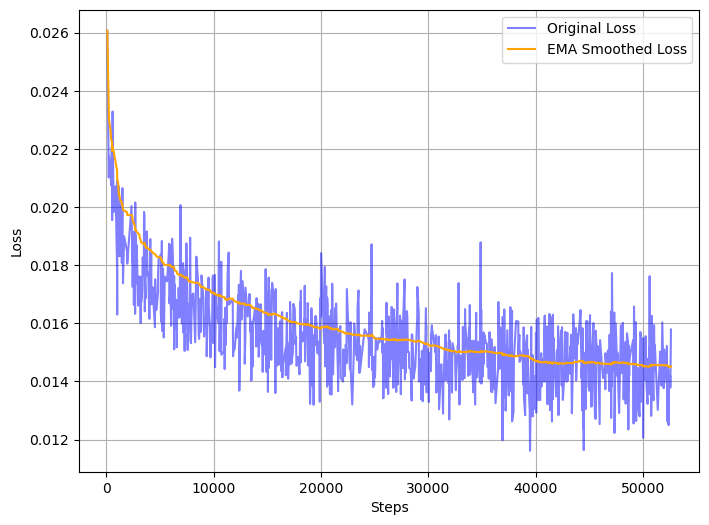

In [6]:
# Load the CSV file
csv_path = "diff_loss.csv"  # Replace with your CSV file path
data = pd.read_csv(csv_path)
steps = data['Step']
loss_values = data['Value']

# Apply Exponential Moving Average (EMA)
alpha = 0.01  # Smoothing factor (adjust as needed)
ema_loss = data['Value'].ewm(alpha=alpha).mean()

# Plot
plt.figure(figsize=(8, 6))
plt.plot(steps, loss_values, label="Original Loss", alpha=0.5, color="blue")
plt.plot(steps, ema_loss, label="EMA Smoothed Loss", color="orange")
plt.xlabel("Steps")
plt.ylabel("Loss")
# plt.title("VAE Training Loss")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
# model = GD3PM(7)
# # state_dict = torch.load("checkpoint_nodediff_ddp_adam_32layers_1536dim.pth", map_location = {'cuda:%d' % 0: 'cuda:%d' % 7})["model"]
# state_dict = torch.load("checkpoint_diff_ddp_adam_32layers_1536nodedim_512edgedim.pth", map_location = {'cuda:%d' % 0: 'cuda:%d' % 7})["model"]

# # Create a new OrderedDict without the 'module.' prefix
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     name = k[7:]  # Remove 'module.'
#     new_state_dict[name] = v

# # Load the parameters into your model and freeze
# model.load_state_dict(new_state_dict)
# model = model.eval()
# for p in model.parameters():
#     p.requires_grad = False

In [ ]:
# sampled_nodes, sampled_edges = model.sample(1)



# for i in range(sampled_nodes.size(0)):
#     SketchDataset.render_graph(sampled_nodes[i,...,1:].cpu(), sampled_edges[i].cpu())

In [2]:
# edges1 = torch.load("data/processed/edges1.pt")
# temp_edges = torch.cat([edges[0:1928133], edges[1928134:2026425], edges[2026426:]], dim = 0)
nodes = torch.load("data/processed/nodes2.pt")
edges = torch.load("data/processed/edges2.pt")

In [4]:
nodes.shape

torch.Size([1426021, 16, 20])

In [6]:
model = GD3PM(device = 0)

temp = ToIscosceles(nodes[0:10].to(0).clone())
temp = torch.cat([1 - temp[...,[0]], temp], dim = -1)
model(temp, edges[0:10].to(0), torch.arange(0, 10, 1, device = 0))

KeyboardInterrupt: 

In [26]:
# nodes = ToIscosceles(BoundingBoxShiftScale(nodes))

In [27]:
def GetUniqueIndices(tensor, num_levels):
    # Step 1: Get min and max values for each feature across batch and nodes
    min_vals, _ = tensor.min(dim=-1, keepdim=True)  # Shape: (batch_size, num_nodes, 1)
    max_vals, _ = tensor.max(dim=-1, keepdim=True)  # Shape: (batch_size, num_nodes, 1)
    
    # Step 2: Normalize each feature to the range [0, 1]
    tensor_normalized = (tensor - min_vals) / (max_vals - min_vals + 1e-8)  # Add small epsilon to avoid division by zero
    
    # Step 3: Scale to the quantization levels
    tensor_scaled = tensor_normalized * (num_levels - 1)
    
    # Step 4: Round to the nearest quantization level
    tensor_quantized = torch.round(tensor_scaled).to(dtype=torch.int32)

    _, inverse_indices, counts = torch.unique(input = tensor_quantized, return_inverse = True, return_counts = True, sorted = False, dim = 0)

    _, permutation_sort = torch.sort(inverse_indices, stable=True) # permutation_sort is the permutation of indices to make the input sorted
    cum_sum = counts.cumsum(0) # End position of each group of duplicates
    cum_sum = torch.cat((torch.tensor([0]), cum_sum[:-1])) # Start position of each group of duplicates
    first_indicies = permutation_sort[cum_sum] # First occurence of tensors

    return first_indicies, permutation_sort, cum_sum
    # # Step 5: Denormalize each feature back to its original range
    # tensor_dequantized = (tensor_quantized / (num_levels - 1)) * (max_vals - min_vals) + min_vals
    
    # return tensor_dequantized

unique_indices, consequtive_duplicate_indices, group_start_indices = GetUniqueIndices(nodes[...,6:], 2 ** 6)
# unique_nodes = nodes[GetUniqueIndices(nodes[...,6:], 2 ** 6)]
# nodes[...,6:] = uniform_quantize(nodes[...,6:], 2 ** 8)

In [30]:
# group_start_indices[20:40]
consequtive_duplicate_indices[22:28]

tensor([ 530490,  574465, 1337191, 1373381, 1435037, 1439081])

In [42]:
idx = 530490
idx2 = 574465
# datalib.render_sketch(SketchDataset.preds_to_sketch(ToNaive(nodes[idx]).cpu(), torch.zeros(16,16,17).cpu()))
# datalib.render_sketch(SketchDataset.preds_to_sketch(ToNaive(nodes[idx2]).cpu(), torch.zeros(16,16,17).cpu()))

sketch = SketchDataset.preds_to_sketch(nodes[idx].cpu(), torch.zeros(16,16,17).cpu())
sketch.entities

OrderedDict([('1', Line [1] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('2', Line [2] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('3', Line [3] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('4', Line [4] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('5', Point [5] ((0.0, 0.0))),
             ('6', Line [6] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('7', Line [7] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('8', Line [8] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('9', Line [9] p(0.0, 0.0) d(nan, nan) param(0, 0.0)),
             ('10', Point [10] ((0.0, 0.0))),
             ('11', Line [11] p(0.5, 0.5) d(-1.0, 0.0) param(0, 1.0)),
             ('12', Line [12] p(0.5, -0.5) d(-1.0, 0.0) param(0, 1.0)),
             ('13', Line [13] p(0.5, 0.5) d(0.0, -1.0) param(0, 1.0)),
             ('14', Line [14] p(-0.5, 0.5) d(0.0, -1.0) param(0, 1.0)),
             ('15', Point [15] ((0.0, 0.0)))])

In [ ]:
# # marginal = nodes.mean(dim = [0,1])[1:6]
# marginal = edges.mean(dim = [0,1,2])[8:]
# marginal[:-1] / marginal[:-1].sum()

In [ ]:
idx = 6
# node1 = nodes[idx]
# edge1 = edges[idx]
sketch = SketchDataset.preds_to_sketch(nodes[idx].cpu(), edges[idx].cpu())
datalib.render_sketch(sketch)
# sketch.constraints
# PredsToJSON(nodes[idx], edges[idx])["feature"]["entities"]

In [2]:
import math

def PredsToJSON(nodes : torch.Tensor, edges : torch.Tensor):
    primitives = []
    constraints = []
    # Add entities
    for idx in range(len(nodes)):
        entity = nodes[idx]
        id = "p" + str(idx)
        isConstructible = bool(entity[0].item() >= 0.5)
        match torch.argmax(entity[1:6]):
            case 0:
                # Create Line
                pnt = entity[6:8]
                startParam = 0
                dir = (entity[8:10] - entity[6:8]) / torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                endParam = torch.linalg.vector_norm(entity[8:10] - entity[6:8])
                line = {
                    "btType": "BTMSketchCurveSegment-155",
                    "startParam": startParam,
                    "endParam": endParam.item(),
                    "geometry": {
                    "btType": "BTCurveGeometryLine-117",
                    "pntX": pnt[0].item(),
                    "pntY": pnt[1].item(),
                    "dirX": dir[0].item(),
                    "dirY": dir[1].item()
                    },
                    "startPointId": id + ".start",
                    "endPointId": id + ".end",
                    "entityId": id,
                    "isConstruction": isConstructible
                }
                primitives.append(line)
            case 1:
                # Create Circle
                center = entity[10:12]
                radius = entity[12]
                circle = {
                    "btType": "BTMSketchCurve-4",
                    "geometry": {
                    "btType": "BTCurveGeometryCircle-115",
                    "radius": radius.item(),  
                    "xCenter": center[0].item(),
                    "yCenter": center[1].item(),  
                    "xDir": 1,
                    "yDir": 0, 
                    "clockwise": False 
                    },
                    "centerId": id + ".center",
                    "entityId": id,
                    "isConstruction": isConstructible
                }
                primitives.append(circle)
            case 2: 
                # Create Arc
                center = entity[13:15]
                radius = entity[15]
                startParam = entity[16] * (2*math.pi)
                endParam = entity[17] * (2*math.pi)
                arc = {
                    "btType": "BTMSketchCurveSegment-155",
                    "startParam": startParam.item(),
                    "endParam": endParam.item(),
                    "geometry": {
                    "btType": "BTCurveGeometryCircle-115",
                    "radius": radius.item(),  
                    "xCenter": center[0].item(),
                    "yCenter": center[1].item(),  
                    "xDir": 1,
                    "yDir": 0, 
                    "clockwise": False 
                    },
                    "startPointId": id + ".start",
                    "endPointId": id + ".end",
                    "centerId": id + ".center",
                    "entityId": id,
                    "isConstruction": isConstructible
                }
                primitives.append(arc)
            case 3:
                # Create Point
                x = entity[18]
                y = entity[19]
                point = {
                    "btType": "BTMSketchPoint-158",
                    "x": x.item(),
                    "y": y.item(),
                    "isConstruction": isConstructible,
                    "entityId": id
                }
                primitives.append(point)
            case _:
                continue

    # Add constraints
    idx = 0
    constraint_types = ["COINCIDENT", "HORIZONTAL", "VERTICAL", "PARALLEL", "PERPENDICULAR", "TANGENT", "MIDPOINT", "EQUAL", "NONE"]
    subprimitive_references = [".start", ".center", ".end", ""] # If the subprimitive reference is None, then the constraint references the whole primitive
    for i in range(edges.size(0)):
        for j in range(edges.size(1)):
            # if i == 2 and j == 3:
            #     x = 5
            constraint = edges[i][j]
            # Extract Constraint Type
            constraintType = constraint_types[torch.argmax(constraint[8:17]).item()]
            if constraintType == "NONE": continue # Skip current loop iteration

            param_ids = ["localFirst", "localSecond"]
            # Adjust reference parameter ids if necessary
            if constraintType == "MIDPOINT": 
                param_ids = ["localEntity1", "localEntity2"]
            
            # Fill constraint parameters
            params = []
            if i == j:
                # Constraint only applies to single entity
                node_ref = "p" + str(i) + subprimitive_references[torch.argmax(constraint[0:4]).item()]
                param1 = {
                    "btType": "BTMParameterString-149",
                    "value": node_ref,
                    "parameterId": param_ids[0]
                }
                params.append(param1)
            else:
                # Constraint applies to 2 primitives
                node_a_ref = "p" + str(i) + subprimitive_references[torch.argmax(constraint[0:4]).item()]
                param1 = {
                    "btType": "BTMParameterString-149",
                    "value": node_a_ref,
                    "parameterId": param_ids[0]
                }
                params.append(param1)

                node_b_ref = "p" + str(j) + subprimitive_references[torch.argmax(constraint[4:8]).item()]
                param2 = {
                    "btType": "BTMParameterString-149",
                    "value": node_b_ref,
                    "parameterId": param_ids[1]
                }
                params.append(param2)
            
            # Add constraint JSON
            id = "c_" + str(idx)
            constraints.append({
                "btType": "BTMSketchConstraint-2",
                "constraintType": constraintType,
                "parameters": params,
                'entityId': id
            })
            idx = idx + 1

    payload = {
        "feature" : {
        "btType": "BTMSketch-151", 
        "featureType": "newSketch", 
        "name": "Sketch 1", 
        "parameters": [
        {
            "btType": "BTMParameterQueryList-148",
            "queries": [
            {
                "btType": "BTMIndividualQuery-138",
                "queryString": "query=qCreatedBy(makeId(\"Front\"), EntityType.FACE);"
            }
            ],
            "parameterId": "sketchPlane" 
        }
        ],
        "entities": primitives,
        "constraints": constraints
        }
    }
    return payload

In [ ]:
import urllib.parse
import requests
import json

url = R'https://cad.onshape.com/documents/ea3676f6eae5d981536d8aa0/w/b3c060a59b0d90358e9904cf/e/c73b7a827e9d662d32f2f6b3'
access_key = "CiR9Ot162KLFIjy4X5685DCH"
secret_key = "MRgWejgCDpru5J11mp0Uk5whGC7dFWrjgTUTlWSzzxvwTwXg"

_, _, docid, _, wid, _, eid = urllib.parse.urlparse(url).path.split('/')

r = requests.post(url = f"https://cad.onshape.com/api/v9/partstudios/d/{docid}/w/{wid}/e/{eid}/features", auth = (access_key, secret_key), json = PredsToJSON(nodes[idx], edges[idx]))

# r.text

# r = requests.get(url = f"https://cad.onshape.com/api/v9/partstudios/d/{docid}/w/{wid}/e/{eid}/features", auth = (access_key, secret_key))

# data = r.json()
# data['features'][0]['constraints']
r.json()

In [ ]:

# onshape_call.add_feature(url, sketch.to_dict(), 'With_Constraints_Sketch')
# solved_sketch_info = onshape_call.get_info(url, 'With_Constraints_Sketch')
# solved_sketch = datalib.Sketch.from_info(solved_sketch_info['geomEntities'])
# datalib.render_sketch(solved_sketch)

In [10]:
''' Clamping is just interpolating with a uniform marginal, k is the interpolation alpha and m is the clamp value '''
import math
gpu_id = "cpu"
D = 5
x0 = torch.eye(n = 1, m = D, device = gpu_id)
k = 0.99
m = math.log((1-k)/((D-1)*k+1))
print(torch.log(k * x0 + (1 - k) / D))
print(torch.log(x0).clamp(m))
# m = -6.23
# e = math.e
# k = -(e ** m - 1) / ((D - 1) * e ** m + 1)

# print(k)
# print(torch.log(k * x0 + (1 - k) / D))

tensor([[-0.0080, -6.2146, -6.2146, -6.2146, -6.2146]])
tensor([[ 0.0000, -6.2066, -6.2066, -6.2066, -6.2066]])


tensor([9.9992e-01, 1.9944e-05, 1.9944e-05, 1.9944e-05, 1.9944e-05])  at  0
tensor([9.9690e-01, 7.7689e-04, 7.6002e-04, 7.8655e-04, 7.7412e-04])  at  1
tensor([0.9953, 0.0012, 0.0012, 0.0012, 0.0012])  at  2
tensor([0.9939, 0.0015, 0.0015, 0.0015, 0.0015])  at  3
tensor([0.9925, 0.0019, 0.0019, 0.0018, 0.0019])  at  4
tensor([0.9910, 0.0022, 0.0022, 0.0023, 0.0023])  at  5
tensor([0.9899, 0.0025, 0.0025, 0.0026, 0.0025])  at  6
tensor([0.9885, 0.0029, 0.0029, 0.0028, 0.0029])  at  7
tensor([0.9872, 0.0032, 0.0033, 0.0032, 0.0032])  at  8
tensor([0.9858, 0.0035, 0.0035, 0.0035, 0.0036])  at  9
tensor([0.9848, 0.0038, 0.0038, 0.0038, 0.0038])  at  10
tensor([0.9835, 0.0042, 0.0041, 0.0041, 0.0041])  at  11
tensor([0.9820, 0.0044, 0.0046, 0.0045, 0.0046])  at  12
tensor([0.9808, 0.0048, 0.0047, 0.0048, 0.0048])  at  13
tensor([0.9789, 0.0053, 0.0052, 0.0053, 0.0054])  at  14
tensor([0.9783, 0.0054, 0.0053, 0.0054, 0.0056])  at  15
tensor([0.9767, 0.0059, 0.0057, 0.0059, 0.0058])  at  16
t

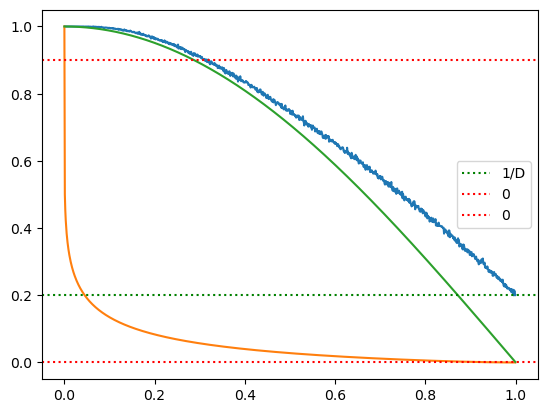

In [7]:
import math
gpu_id = "cpu"
D = 5
x0 = torch.eye(n = 1, m = D, device = gpu_id)
t = torch.arange(0, 1, 1 / (1000 + 1), device = gpu_id)
min = -10
v = abs(min)
s = 16
a_bar = torch.cos(t * torch.pi / 2) # (1-t) * (1 - t ** (1/s)) + (t) * (torch.exp(t * -s)) # 1 - t ** (1/16) # -torch.log(t) / 32 # torch.exp(t * -16) # 1 - t ** (1/16) # torch.cos(t * torch.pi / 2) ** (16)
k = a_bar[9]
da_bar = torch.log((1 - a_bar) / ((D - 1) * a_bar + 1))
da_bar = da_bar ** 2
da_bar = da_bar / (da_bar + da_bar[1])
da_bar[0] = 1

alpha = torch.zeros(1000, device = gpu_id)

for i in range(1000):
    x = k * x0.expand(10000, -1) + (1 - k) / D

    noise = torch.randn_like(x)
    latent = torch.softmax(da_bar[i].sqrt() * x.log() + (1 - da_bar[i]).sqrt() * noise, dim = -1)
    print(latent.mean(0), " at ", i)

    y = F.one_hot(torch.argmax(latent, dim = -1), D).float().mean(0).squeeze()

    alpha[i] = y[0]

plt.plot(t[1:].cpu(), alpha.cpu())
plt.plot(t.cpu(), da_bar.cpu())
plt.plot(t.cpu(), a_bar.cpu())
plt.axhline(y=1/D, color='g', linestyle=':', label='1/D')
plt.axhline(y=0, color='r', linestyle=':', label='0')
plt.axhline(y=0.9, color='r', linestyle=':', label='0')
plt.legend()

In [ ]:
# # noise_scheduler = CosineNoiseScheduler(1000, 0)
# # idx = 205
# # temp = torch.cat([1 - nodes[idx,...,[0]], nodes[idx]], dim = -1)
# # for i in range(0, 1000, 100):
# #     time = torch.ones(size = (1,), dtype = torch.int32, device = 0) * i
# #     noisy_nodes, noisy_edges = noise_scheduler(temp.unsqueeze(0).to(0), edges[[idx]].to(0), time)
# #     SketchDataset.render_graph(noisy_nodes[0,...,1:].cpu(), edges[0].cpu())

# noise_scheduler = CosineNoiseScheduler(1000, 0)
# idx = 200
# gtn, gte = torch.cat([1 - nodes[idx,...,[0]], nodes[idx]], dim = -1).to(0), edges[[idx]].to(0)
# snodes, sedges = noise_scheduler.sample_latent(1)
# for i in reversed(range(1, 1000)):
#     snodes[...,0:2] = noise_scheduler.discrete_posterior_step(gtn[...,0:2], snodes[...,0:2], i)
#     snodes[...,2:7] = noise_scheduler.discrete_posterior_step(gtn[...,2:7], snodes[...,2:7], i)
#     snodes[...,7:] = noise_scheduler.continuous_posterior_step(gtn[...,7:], snodes[...,7:], i)

#     edges_shape = sedges.shape
#     pred_edges = gte.view(edges_shape[0], -1, edges_shape[-1])
#     sedges = sedges.view(edges_shape[0], -1, edges_shape[-1])

#     sedges[...,0:4] = noise_scheduler.discrete_posterior_step(pred_edges[...,0:4], sedges[...,0:4], i)
#     sedges[...,4:8] = noise_scheduler.discrete_posterior_step(pred_edges[...,4:8], sedges[...,4:8], i)
#     sedges[...,8:] = noise_scheduler.discrete_posterior_step(pred_edges[...,8:], sedges[...,8:], i)

#     sedges = sedges.view(edges_shape)

#     if i % 100 == 1:
#         SketchDataset.render_graph(snodes[0,...,1:].cpu(), sedges[0].cpu())

In [3]:
nodes = torch.load("data/processed/nodes2.pt")
edges = torch.load("data/processed/edges1.pt")

In [17]:
import math

'''Changes arc parameters from naive representation to the center, start, and end points'''
@torch.no_grad()
def ToIscosceles(nodes):
    # To Iscosceles representation
    c = nodes[...,13:15] 
    r = nodes[...,15,None] 
    alpha = nodes[...,16,None] * 2 * math.pi 
    beta = nodes[...,17,None] * 2 * math.pi 

    a = c + r * torch.cat([alpha.cos(), alpha.sin()], dim = -1)
    b = c + r * torch.cat([beta.cos(), beta.sin()], dim = -1)

    nodes[...,13:15] = c
    nodes[...,15:17] = a
    nodes = torch.cat([nodes[...,:17], b, nodes[...,18:]], dim = -1)
    return nodes

'''Changes arc parameters from iscoseles representation to the center, radius, and terminating angles'''
@torch.no_grad()
def ToNaive(nodes):
    c = nodes[...,13:15]
    a = nodes[...,15:17]
    b = nodes[...,17:19]
    r = torch.sum((a - c) ** 2, dim = -1, keepdim = True).sqrt()

    al = (a - c)
    al = (torch.atan2(al[...,1], al[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)
    be = (b - c)
    be = (torch.atan2(be[...,1], be[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)

    nodes[...,13:18] = torch.cat([c, r, al, be], dim = -1)
    nodes[nodes.isnan()] = 0

    indices = torch.arange(nodes.size(-1))  # Generate all indices
    excluded_indices = indices[indices != 18]  # Filter out index 18
    nodes = nodes[..., excluded_indices]
    return nodes

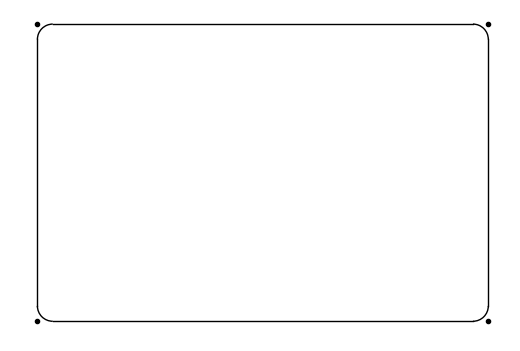

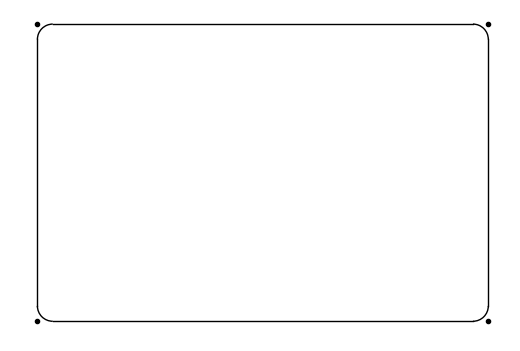

In [18]:
# from utils import ToCenter, BoundingBoxShiftScale, ToIscosceles, ToNaive
X = nodes[[200, 246, 204, 205]]
# X = ToIscosceles(BoundingBoxShiftScale(nodes[[200, 246, 204, 205]]))
# for i in range(len(X)):
#     SketchDataset.render_graph(X[i].cpu(), edges[i])
#     # SketchDataset.render_graph(ToNaive(X[i]).cpu(), edges[i])
SketchDataset.render_graph(X[0], edges[0])
SketchDataset.render_graph(ToNaive(ToIscosceles(X[0])), edges[0])
print()

In [ ]:
# import math

# @torch.no_grad()
# def batched_dot(a, b):
#     return (a * b).sum(dim = -1, keepdim = True)

# @torch.no_grad()
# def ToIscosceles(x):
#     m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

#     # To Iscosceles representation
#     y = x.to(torch.double)
#     c = y[...,13:15] # torch.tensor([1.76, 2.21])
#     r = y[...,15,None] # torch.tensor([1.0])
#     alpha = y[...,16,None] * 2 * math.pi # torch.tensor([0.211])
#     beta = y[...,17,None] * 2 * math.pi # torch.tensor([0.987])

#     a = c + r * torch.cat([alpha.cos(), alpha.sin()], dim = -1)
#     b = c + r * torch.cat([beta.cos(), beta.sin()], dim = -1)
#     r_s = torch.where(batched_dot((a - b) @ m, a - c) > 0, -r, r)

#     y[...,13:15] = a
#     y[...,15:17] = b
#     y[...,17] = r_s.squeeze(-1)

#     return y.to(torch.float32)

# @torch.no_grad()
# def ToNaive(x):
#     m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

#     x = x.clone().to(torch.double)
#     a = x[...,13:15]
#     b = x[...,15:17]
#     r_s = x[...,17,None]

#     # To Naive representation
#     d = a - b

#     w = batched_dot(d, d).sqrt()
#     h = torch.sqrt(r_s ** 2 - w ** 2 / 4)

#     c = b + d / 2 + h / w * d @ m * r_s.sign()

#     al = (a - c) / r_s.abs()
#     al = (torch.atan2(al[...,1], al[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)
#     be = (b - c) / r_s.abs()
#     be = (torch.atan2(be[...,1], be[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)

#     x[...,13:18] = torch.cat([c, torch.abs(r_s), al, be], dim = -1)
#     x[x.isnan()] = 0
#     return x.to(torch.float)

# X = ToIscosceles(nodes[[200, 246, 204, 205]])
# for i in range(len(X)):
#     SketchDataset.render_graph(ToNaive(X[i]).cpu(), edges[i])

In [ ]:
# '''Moves the Center of mass to the origin expects naive representation of arcs'''
# @torch.no_grad()
# def BoundingBoxScale(nodes):
#     # Rescale each sketch so that either the width or height is unit length
#     val_indices = [6,7,8,9,10,11,12,13,14,15,18,19]
#     x_indices = [6,8,10,13,18]
#     y_indices = [7,9,11,14,19]

#     max_x = torch.amax(nodes[...,x_indices], dim = [1, 2], keepdim = True)
#     min_x = torch.amin(nodes[...,x_indices], dim = [1, 2], keepdim = True)
#     max_y = torch.amax(nodes[...,y_indices], dim = [1, 2], keepdim = True)
#     min_y = torch.amin(nodes[...,y_indices], dim = [1, 2], keepdim = True)

#     width = max_x - min_x
#     height = max_y - min_y

#     nodes[...,val_indices] = nodes[...,val_indices] / torch.where(width > height, width, height)

#     return nodes

# X = nodes[[200, 246, 204, 205]] # BoundingBoxScale(nodes[[200, 246, 204, 205]])
# for i in range(len(X)):
#     SketchDataset.render_graph(X[i].cpu(), edges[i])

In [3]:
# Move center of mass for each sketch to the origin
x_indices = [6,8,10,13,18]
y_indices = [7,9,11,14,19]

an = nodes.sum(dim = 1) # aggregate nodes

denom = (24 - an[:,5] + an[:,1])
avg_x = an[:,x_indices].sum(dim = -1) / denom
avg_y = an[:,y_indices].sum(dim = -1) / denom

norm_nodes = nodes.clone()

mask = torch.cat([nodes[...,[1]], nodes[...,1:5]], dim = -1)
norm_nodes[...,x_indices] = (norm_nodes[...,x_indices] - avg_x[:,None,None]) * mask
norm_nodes[...,y_indices] = (norm_nodes[...,y_indices] - avg_y[:,None,None]) * mask

# Rescale each sketch so that the maximum or minimum parameter is 1 or -1 respectively
val_indices = [6,7,8,9,10,11,12,13,14,15,18,19]
norm_nodes[...,val_indices] = norm_nodes[...,val_indices] / torch.amax(torch.abs(norm_nodes[...,val_indices]), dim = [1, 2], keepdim = True)

# # Rescale each sketch so that their encapsulating rectangle has a maximum sidelength of 1
# h_extremes = torch.cat([norm_nodes[...,[6,8,18]], norm_nodes[...,[10]] + norm_nodes[...,[12]], norm_nodes[...,[10]] - norm_nodes[...,[12]], norm_nodes[...,[13]] + norm_nodes[...,[15]], norm_nodes[...,[13]] - norm_nodes[...,[15]]], dim = -1)
# v_extremes = torch.cat([norm_nodes[...,[7,9,19]], norm_nodes[...,[11]] + norm_nodes[...,[12]], norm_nodes[...,[11]] - norm_nodes[...,[12]], norm_nodes[...,[14]] + norm_nodes[...,[15]], norm_nodes[...,[14]] - norm_nodes[...,[15]]], dim = -1)
# min_h, max_h = torch.amin(h_extremes, dim = [1,2]), torch.amax(h_extremes, dim = [1,2])
# min_v, max_v = torch.amin(v_extremes, dim = [1,2]), torch.amax(v_extremes, dim = [1,2])

# scale = torch.max(max_h - min_h, max_v - min_v)

# val_indices = [6,7,8,9,10,11,12,13,14,15,18,19]
# norm_nodes[...,val_indices] = norm_nodes[...,val_indices] / scale[:,None,None]

In [11]:
i = 0
temp = norm_nodes[i].clone()
# temp[:,x_indices].sum()
# SketchDataset.render_graph(temp.cpu(), torch.zeros(24, 24, 19))
# print("")

# h_extremes = torch.cat([temp[:,[6,8,18]], temp[:,[10]] + temp[:,[12]], temp[:,[10]] - temp[:,[12]], temp[:,[13]] + temp[:,[15]], temp[:,[13]] - temp[:,[15]]], dim = -1)
# v_extremes = torch.cat([temp[:,[7,9,19]], temp[:,[11]] + temp[:,[12]], temp[:,[11]] - temp[:,[12]], temp[:,[14]] + temp[:,[15]], temp[:,[14]] - temp[:,[15]]], dim = -1)
# min_h, max_h = torch.aminmax(h_extremes)
# min_v, max_v = torch.aminmax(v_extremes)

# scale = torch.max(max_h - min_h, max_v - min_v)

# val_indices = [6,7,8,9,10,11,12,13,14,15,18,19]
# temp[:,val_indices] = temp[:,val_indices] / scale

# h_extremes = torch.cat([temp[:,[6,8,18]], temp[:,[10]] + temp[:,[12]], temp[:,[10]] - temp[:,[12]], temp[:,[13]] + temp[:,[15]], temp[:,[13]] - temp[:,[15]]], dim = -1)
# v_extremes = torch.cat([temp[:,[7,9,19]], temp[:,[11]] + temp[:,[12]], temp[:,[11]] - temp[:,[12]], temp[:,[14]] + temp[:,[15]], temp[:,[14]] - temp[:,[15]]], dim = -1)
# min_h, max_h = torch.aminmax(h_extremes)
# min_v, max_v = torch.aminmax(v_extremes)

# max_h - min_h, max_v - min_v


# temp[:,y_indices].sum()
# temp[:,x_indices].sum()
# num_none = nodes[i].sum(dim = 0)[5]
# num_line = nodes[i].sum(dim = 0)[1]
# temp = temp[:,[6,8,10,13,18]] 

# avg_x = temp.sum() / (24 - num_none + num_line)

# mask = torch.cat([nodes[i,:,[1]], nodes[i,:,1:5]], dim = -1)

# print(((temp - avg_x) * mask).sum())


tensor(4.1723e-07)

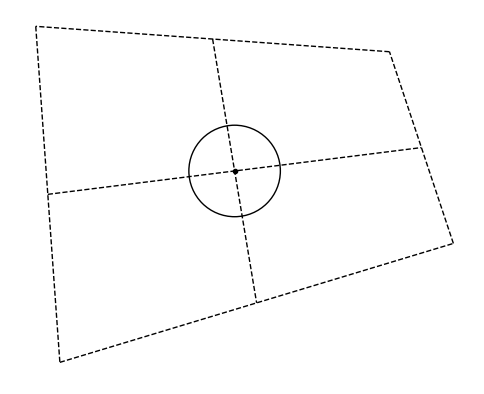

In [23]:
SketchDataset.render_graph(norm_nodes[0].cpu(), torch.zeros(24, 24, 19))
print("")

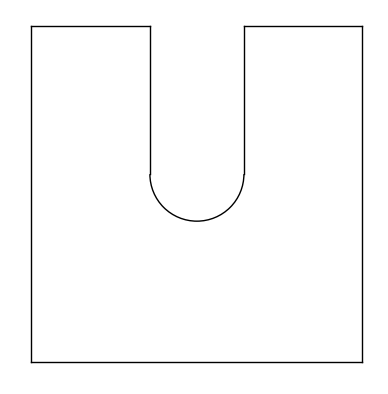

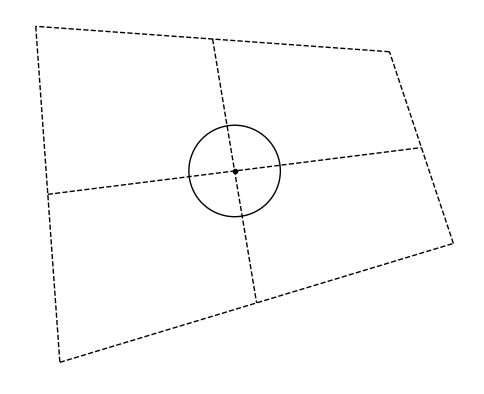

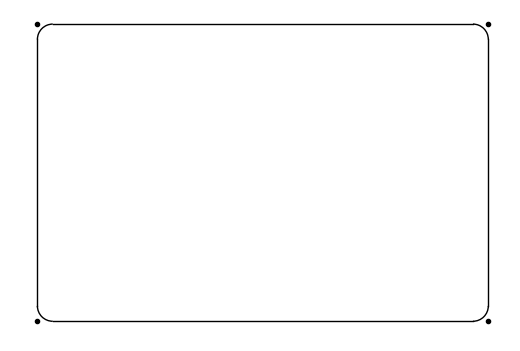

In [ ]:
SketchDataset.render_graph(nodes[1200].cpu(), torch.zeros(24, 24, 19))
SketchDataset.render_graph(nodes[0].cpu(), torch.zeros(24, 24, 19))
SketchDataset.render_graph(nodes[200].cpu(), torch.zeros(24, 24, 19))

print("")

In [ ]:
from collections import OrderedDict

def DDP_to_normal(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # Remove 'module.'
        new_state_dict[name] = v

    return new_state_dict

def freeze_model(model):
    model = model.eval()
    for p in model.parameters():
        p.requires_grad = False

In [ ]:
from model2 import GVAE
# from temp_model import Sharpener
from sampler_trainer import Sampler

gpu_id = 0

sampler = Sampler(gpu_id)
vae = GVAE(gpu_id)
# sharpener = Sharpener(gpu_id)

# model.load_state_dict(torch.load("model_checkpoint_gaussdiff_ddp_Adam_32tflayers.pth"))
# Load the original saved file with DataParallel
sampler_state_dict = torch.load('checkpoints/model_checkpoint_sampler_ddp_Adam_depth_32_1.pth')
vae_state_dict = torch.load('checkpoints/model_checkpoint_gvae_ddp_Adam_mse-25_kld-.001_16layers16heads256hiddenencoder_16layers16heads256hiddendecoder_embedim1024_tempnodedim128_relu_after_node_layernorm.pth')
# sharpener_state_dict = torch.load('model_checkpoint_sharpener_ddp_Adam_16tflayers.pth')


# Load the parameters into your model and freeze
sampler.load_state_dict(DDP_to_normal(sampler_state_dict))
vae.load_state_dict(DDP_to_normal(vae_state_dict))
# sharpener.load_state_dict(DDP_to_normal(sharpener_state_dict))

freeze_model(sampler)
freeze_model(vae)
# freeze_model(sharpener)

In [ ]:
T = sampler.max_timestep
a_bar = torch.cos(0.5 * torch.pi * (torch.arange(0.0, 1.0, 1/(T + 1)) + .008) / 1.008) ** 2
a_bar = a_bar / a_bar[0]
a_bar = a_bar.to(gpu_id)

a = a_bar[1:] / a_bar[:-1]
a = torch.cat([a, torch.tensor([0.0]).to(gpu_id)])

sqrt_a = a.sqrt()
sqrt_a_bar = a_bar.sqrt().to(gpu_id)
sqrt_b_bar = (1 - a_bar).sqrt().to(gpu_id)

sqrt_post_var = torch.cat([torch.tensor([0.0]).to(gpu_id), (a_bar[:-1] / a_bar[1:] * (1 - a[1:]))]).sqrt()

def sample_latent(batch_size):
    sampled_latents = torch.randn((batch_size, 1024)).to(gpu_id)

    for i in reversed(range(1, sampler.max_timestep)):
        pred_latents = sampler(sampled_latents, torch.full(size = (batch_size,), fill_value = i).to(gpu_id))
      
        denoised_mean = (sqrt_a_bar[i - 1] * (1 - a[i]) * pred_latents + sqrt_a[i] * (1 - a_bar[i - 1]) * sampled_latents) / (1 - a_bar[i])
        if i > 1:
            sampled_latents = denoised_mean + sqrt_post_var[i] * torch.randn_like(denoised_mean)
        else:
            sampled_latents = denoised_mean
    
    return sampled_latents

In [ ]:
with torch.no_grad():
    latents = sample_latent(4)
    decoded_nodes, decoded_edges = vae.decoder(latents)

In [ ]:
import urllib.parse
import requests
import json

url = R'https://cad.onshape.com/documents/ea3676f6eae5d981536d8aa0/w/b3c060a59b0d90358e9904cf/e/c73b7a827e9d662d32f2f6b3'
access_key = "CiR9Ot162KLFIjy4X5685DCH"
secret_key = "MRgWejgCDpru5J11mp0Uk5whGC7dFWrjgTUTlWSzzxvwTwXg"

_, _, docid, _, wid, _, eid = urllib.parse.urlparse(url).path.split('/')

r = requests.post(url = f"https://cad.onshape.com/api/v9/partstudios/d/{docid}/w/{wid}/e/{eid}/features", auth = (access_key, secret_key), json = PredsToJSON(decoded_nodes[idx].cpu(), decoded_edges[idx].cpu()))

# r.text

# r = requests.get(url = f"https://cad.onshape.com/api/v9/partstudios/d/{docid}/w/{wid}/e/{eid}/features", auth = (access_key, secret_key))

# data = r.json()
# data['features'][0]['constraints']
r.json()

In [3]:
embedding_dataset = torch.load("embedding_dataset.pth")

/home/chereds/.conda/envs/thesis/lib/python3.11/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


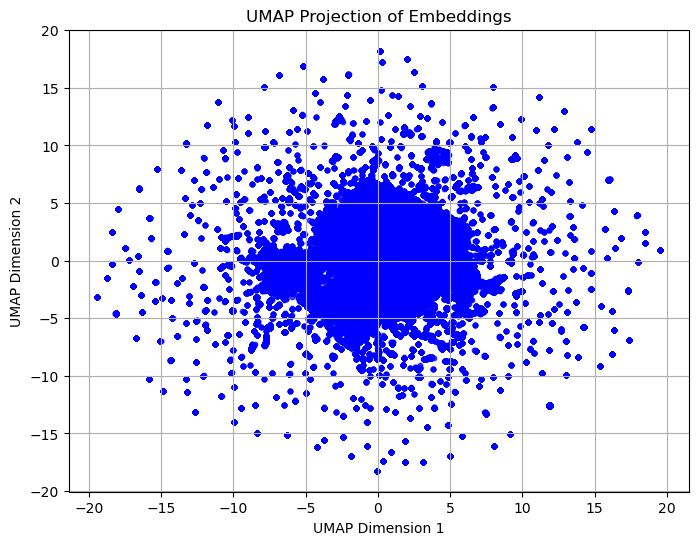

In [2]:
import torch
import umap
import matplotlib.pyplot as plt

# Example embeddings as a PyTorch tensor
embeddings = torch.load("embedding_dataset.pth")[0:200_000][0]  # Replace with your embeddings

# Convert the PyTorch tensor to a NumPy array
embeddings_np = embeddings.detach().cpu().numpy()

# Reduce dimensionality to 2D using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_np)

# Plot the UMAP
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7, s=10)
plt.title("UMAP Projection of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()


In [3]:
means = embedding_dataset[0:200_000][0]

means.shape

torch.Size([200000, 1024])

(200000, 2)


/tmp/ipykernel_1590/2389947231.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


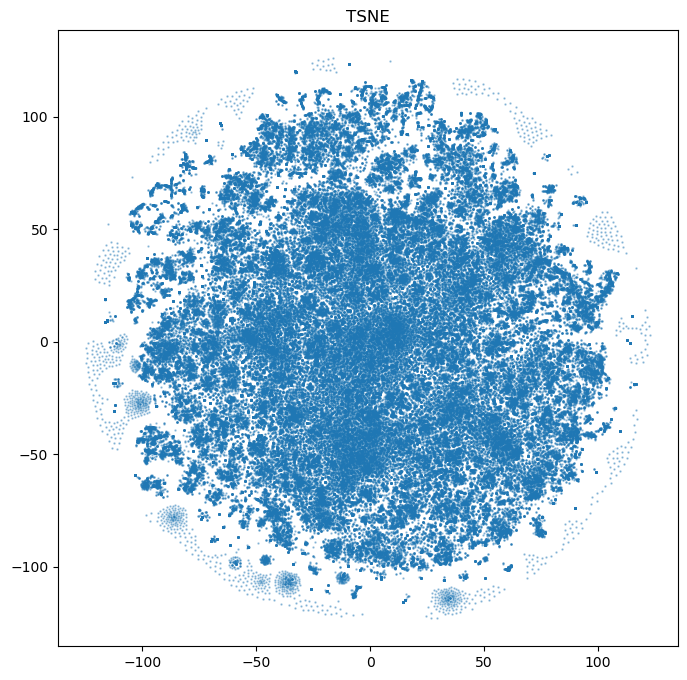

In [4]:
projections = TSNE(n_components=2, learning_rate=500, n_iter = 2000, init='random', perplexity = 50).fit_transform(means)

print(projections.shape)

# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )

# Create the scatter
ax.scatter(
    x=projections[:,0],
    y=projections[:,1],
    # cmap=plt.cm.get_cmap('Paired'),
    alpha=0.4,
    s=0.5)
plt.show()